**Initialization**

In [1]:
import numpy as np

import datetime as dt

%tensorflow_version 2.x
import tensorflow as tf

import matplotlib.pyplot as plt

# **Task 1: Data set**

The Cifar10 dataset comes directly in a two-part dataset for training and test data. The training dataset contains 50000 image-label pairs and the test dataset 10000 image-label pairs. The labels are displayed as numbers from 0 to 9. Among other things in the following code snippet these numbers are mapped to their string label class names. The images in the datasets come up with a fixed shape of 32 x 32 x 3. Thus no resizing is necessary. 

Additionally, some example images of the dataset are displayed with the corresponding string label class name.

170500096/170498071 [==============================] - 4s 0us/step
Training inputs shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test inputs shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


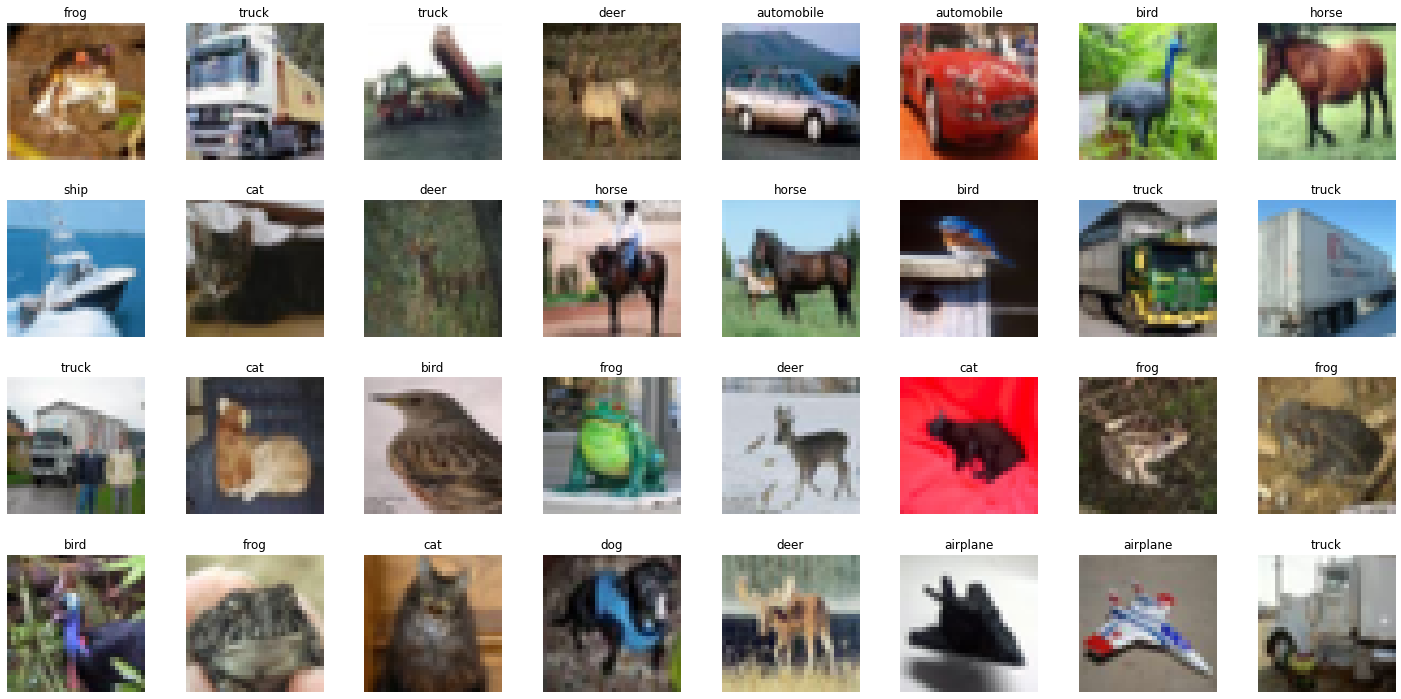

In [2]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.cifar10.load_data()

print("Training inputs shape: " + str(training_inputs.shape))
print("Training labels shape: " + str(training_labels.shape))
print("Test inputs shape: " + str(test_inputs.shape))
print("Test labels shape: " + str(test_labels.shape))

label_encoding = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(4, 8, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(32):
  image = training_inputs[i]
  label = label_encoding[training_labels[i][-1]]

  ax[i].imshow(image)
  ax[i].set_title(label)
  ax[i].axis("off")

Input pipeline

In [3]:
batch_size = 128

# Creates tensorflow datasets for the training and test data.
training_dataset = tf.data.Dataset.from_tensor_slices((training_inputs, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

# Conducts the normalization of the inputs (images) and the one-hot-encoding of the targets.
training_dataset = training_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))  # tf.squeeze(tar) to remove dimensions of size 1 from the shape of the target-tensors.
test_dataset = test_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))     
                                                                                          
# Batches, shuffles and prefetches the training- and test datasets.
training_dataset = training_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)
test_dataset = test_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)

# **Task 2.2: Model - DenseNet**

**Class TransitionLayer**

Implementation of a callable Transition Layer for the DenseNet. 

This one should include:

*   Concolutional Layer
*   Batch Normalization
*   Activation Function ReLu
*   Pooling Layer (AveragePooling)













In [4]:
# Description: The class TransitionLayer describes a transition layer of a DenseNet.
class TransitionLayer(tf.keras.layers.Layer): 
  
  def __init__(self, num_channels_trans_layer):
    super(TransitionLayer, self).__init__()

    self.conv_1 = tf.keras.layers.Conv2D(filters = num_channels_trans_layer,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         
    self.activ_1 = tf.keras.activations.relu                         
    self.aver_pool_1 = tf.keras.layers.AveragePooling2D(strides=(2, 2), padding = 'same')   #Without strides?

  # Description: This function conducts one forward-step of the transition layer. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.aver_pool_1(x)
    return x

**Class ConvolutionalBlock**

This class is needed to create a Dense Block. It includes one convolutional layer. When calling, the forward step is conducted and the output of the layer is concatenate with the input itself. The result of the concatenation is the output of the convolutional block.

In [5]:
# Description: The class ConvolutionalBlock describes a convolutional block of a DenseBlock.
class ConvolutionalBlock(tf.keras.layers.Layer): 
  
  def __init__(self, num_filter):
    super(ConvolutionalBlock, self).__init__()

    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_1 = tf.keras.activations.relu                
    self.conv_1 = tf.keras.layers.Conv2D(filters = num_filter,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.conv_2 = tf.keras.layers.Conv2D(filters = num_filter,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_2 = tf.keras.activations.relu          
    self.concat = tf.keras.layers.Concatenate()               

  # Description: This function conducts one forward-step of the convolutional block. Therefore the block output
  #              is concatenated with the block input. The python decorator @tf.function is used to bundle multiple 
  #              computations into one computational graph.
  #              @parameters: block_input, training (to differ between training and test calls of the residual block)
  #              @returns: block_output
  @tf.function
  def call(self, block_input, training = True):
    x = self.batch_norm_1(block_input, training)
    x = self.activ_1(x)
    x = self.conv_1(x)
    x = self.conv_2(x) 
    x = self.batch_norm_2(x, training)
    x = self.activ_2(x)

    block_output = self.concat([x, block_input]) 
    return block_output

**Class DenseBlock**

Implementation of the Dense Blocks for the DenseNet. They include as many convolutional blocks as the init parameter list_num_filter defines. The total number of convolutional layers of the Dense Block is list_num_filter.

In [6]:
# Description: The class DenseBlock describes a dense block of a DenseNet.
class DenseBlock(tf.keras.layers.Layer): 

  def __init__(self, list_num_filter):
    super(DenseBlock, self).__init__()

    self.convolutional_blocks = []
    for num_filter in list_num_filter:
      self.convolutional_blocks.append(ConvolutionalBlock(num_filter))

  # Description: This function conducts one forward-step of the dense block. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (output) x
  @tf.function
  def call(self, x, training = True):
    for conv_block in self.convolutional_blocks:
      x = conv_block(x, training)
    return x

**Class DenseNet**

In [7]:
# The class DenseNet describes a dense convolutional neural network with a feature extractor and a classifier.
class DenseNet(tf.keras.Model): 
  
  def __init__(self, num_dense_blocks, list_num_filter, growth_rate):
    super(DenseNet, self).__init__()
    num_conv_blocks = len(list_num_filter)
    # Feature extractor
    self.conv_1 = tf.keras.layers.Conv2D(filters = 32,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (32, 32, 3))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_1 = tf.keras.activations.relu   

    num_channels_trans_layer = growth_rate * num_conv_blocks
    self.dense_blocks_and_trans_layers = []
    for _ in range(num_dense_blocks - 1):                         # The last dense block does not need a transition layer -> num_dense_blocks - 1 
      self.dense_blocks_and_trans_layers.append(DenseBlock(list_num_filter))   
      self.dense_blocks_and_trans_layers.append(TransitionLayer(num_channels_trans_layer)) 
    self.last_dense_block = DenseBlock(list_num_filter)

    # Classifier
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dropout = tf.keras.layers.Dropout(rate = 0.5)                                               # (5)    
    self.output_layer = tf.keras.layers.Dense(10, 
                                              activation=tf.keras.activations.softmax)#,
                                              #kernel_initializer = tf.keras.initializers.glorot_normal,   
                                              #bias_initializer = 'zeros',                                 
                                              #kernel_regularizer = tf.keras.regularizers.L2(0.01))

  # Description: This function conducts one forward-step of the Dense CNN. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)

    for i in self.dense_blocks_and_trans_layers:
      x = i(x, training)
    x = self.last_dense_block(x, training)

    x = self.global_pool(x)
    x = self.dropout(x, training)
    x = self.output_layer(x)
    return x

# **Task 3: Training and Analysis**

In [8]:
# Description: This function conducts a forward-step and the backpropagation of a CNN. It does not matter whether the CNN is a ResNet or 
#              a DenseNet (this is defined by the parameter model). Additionally, the average training loss and accuracy is determined.
#              @parameters: model, training_data, loss_fn, optimizer, training (to differ between training and test calls of the CNN)
#              @returns: training_loss, training_accuracy
#@tf.function
def training_step(model, training_data, loss_fn, optimizer, training = True):
  training_losses = []
  training_accuracies = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction = model(input, training)
      current_training_loss = loss_fn(target, prediction)+ tf.math.reduce_sum(model.losses)   # (3)
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())

    current_training_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    training_accuracies.append(np.mean(current_training_accuracy))  
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy


# Description: This function determines the average test loss and accuracy of a CNN. It does not matter 
#              whether the CNN is a ResNet or a DenseNet (this is defined by the parameter model).
#              @parameters: model, test_data, loss_fn, training (to differ between training and test calls of the CNN)
#              @returns: test_loss, test_accuracy
#@tf.function
def test(model, test_data, loss_fn, training = False):
  test_losses = []
  test_accuracies = []

  for (input, target) in test_data:
    prediction = model(input, training)
    
    current_test_loss = loss_fn(target, prediction)
    test_losses.append(current_test_loss.numpy())

    current_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_accuracies.append(np.mean(current_test_accuracy))   
    
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)
  return test_loss, test_accuracy

Epoch 0
2020-12-08 10:05:47.661951
Training accuracy: 0.4169437340153453
Test accuracy: 0.14448180379746836
Epoch 1
2020-12-08 10:06:34.766803
Training accuracy: 0.5766104539641944
Test accuracy: 0.3058742088607595
Epoch 2
2020-12-08 10:07:09.125544
Training accuracy: 0.6300991048593351
Test accuracy: 0.5498417721518988
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dense_block (DenseBlock)     multiple                  35136     
_________________________________________________________________
transition_layer (Transition multiple                  9576      
_________________________________________________________________

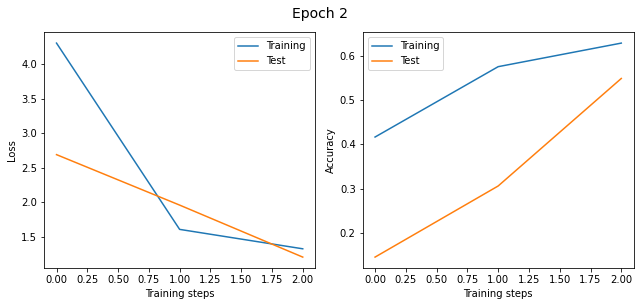

Epoch 3
2020-12-08 10:07:43.739610
Training accuracy: 0.6611373081841432
Test accuracy: 0.4506526898734177
Epoch 4
2020-12-08 10:08:17.976044
Training accuracy: 0.6897538363171356
Test accuracy: 0.33939873417721517
Epoch 5
2020-12-08 10:08:51.889110
Training accuracy: 0.7118765984654731
Test accuracy: 0.6010680379746836
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dense_block (DenseBlock)     multiple                  35136     
_________________________________________________________________
transition_layer (Transition multiple                  9576      
_________________________________________________________________

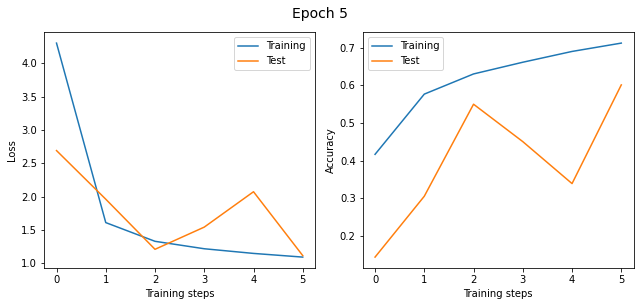

Epoch 6
2020-12-08 10:09:26.320147
Training accuracy: 0.7296115728900255
Test accuracy: 0.582871835443038
Epoch 7
2020-12-08 10:10:00.283920
Training accuracy: 0.7429187979539642
Test accuracy: 0.47043117088607594
Epoch 8
2020-12-08 10:10:34.128018
Training accuracy: 0.7522618286445012
Test accuracy: 0.5176028481012658
Epoch 9
2020-12-08 10:11:08.010715
Training accuracy: 0.7603980179028134
Test accuracy: 0.41386471518987344
Epoch 10
2020-12-08 10:11:41.531940
Training accuracy: 0.7669677109974424
Test accuracy: 0.5597310126582279
Epoch 11
2020-12-08 10:12:15.203707
Training accuracy: 0.7720828005115089
Test accuracy: 0.4620253164556962
Epoch 12
2020-12-08 10:12:48.701499
Training accuracy: 0.7790161445012788
Test accuracy: 0.6286590189873418
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
______________________________

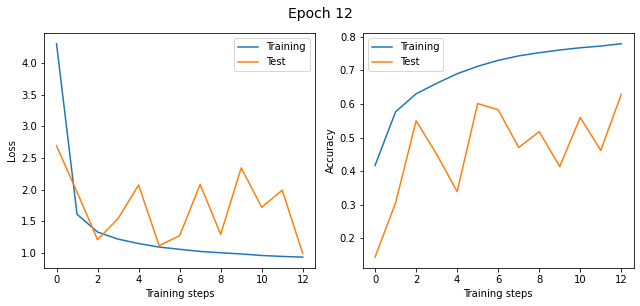

Epoch 13
2020-12-08 10:13:22.674374
Training accuracy: 0.7850863171355499
Test accuracy: 0.6605023734177216
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dense_block (DenseBlock)     multiple                  35136     
_________________________________________________________________
transition_layer (Transition multiple                  9576      
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  39456     
_________________________________________________________________
transition_layer_1 (Transiti multiple                  12456     
_______________

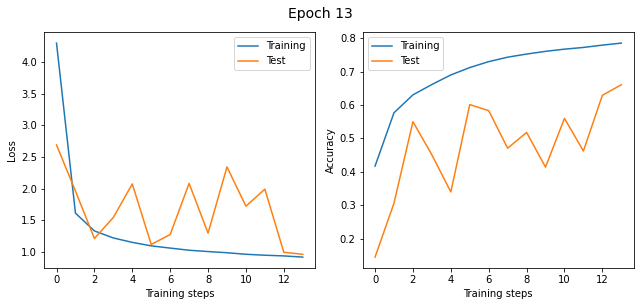

Epoch 14
2020-12-08 10:13:56.679945
Training accuracy: 0.7902773337595909
Test accuracy: 0.7421875
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dense_block (DenseBlock)     multiple                  35136     
_________________________________________________________________
transition_layer (Transition multiple                  9576      
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  39456     
_________________________________________________________________
transition_layer_1 (Transiti multiple                  12456     
________________________

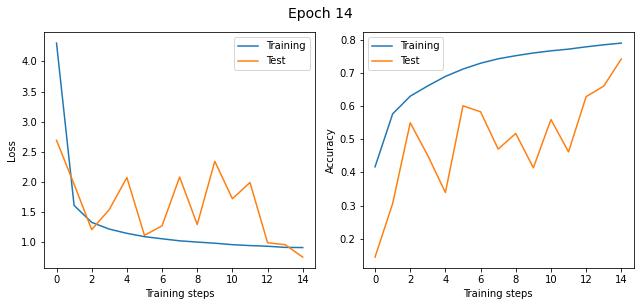

Epoch 15
2020-12-08 10:14:30.932370
Training accuracy: 0.7939777813299232
Test accuracy: 0.653876582278481
Epoch 16
2020-12-08 10:15:04.620551
Training accuracy: 0.7947690217391304
Test accuracy: 0.7059928797468354
Epoch 17
2020-12-08 10:15:38.232719
Training accuracy: 0.7985733695652174
Test accuracy: 0.6692049050632911
Epoch 18
2020-12-08 10:16:11.827850
Training accuracy: 0.8008631713554987
Test accuracy: 0.5903876582278481
Epoch 19
2020-12-08 10:16:45.178510
Training accuracy: 0.8001238810741688
Test accuracy: 0.6683148734177216
Epoch 20
2020-12-08 10:17:18.530733
Training accuracy: 0.8040361253196932
Test accuracy: 0.6002768987341772
Epoch 21
2020-12-08 10:17:51.906050
Training accuracy: 0.8038083439897699
Test accuracy: 0.6703916139240507
Epoch 22
2020-12-08 10:18:25.371111
Training accuracy: 0.8073609335038364
Test accuracy: 0.6928401898734177
Epoch 23
2020-12-08 10:18:58.802252
Training accuracy: 0.8098665281329923
Test accuracy: 0.7652294303797469
Model: "dense_net"
__________

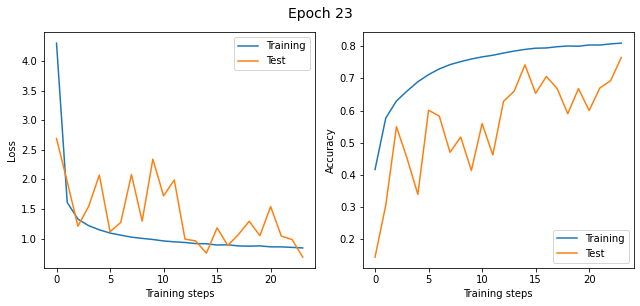

Epoch 24
2020-12-08 10:19:32.561338
Training accuracy: 0.8139106457800511
Test accuracy: 0.7042128164556962
Epoch 25
2020-12-08 10:20:06.053172
Training accuracy: 0.811141304347826
Test accuracy: 0.6817642405063291
Epoch 26
2020-12-08 10:20:39.408290
Training accuracy: 0.813706841432225
Test accuracy: 0.7624604430379747
Epoch 27
2020-12-08 10:21:12.936417
Training accuracy: 0.8167119565217392
Test accuracy: 0.6167919303797469
Epoch 28
2020-12-08 10:21:46.373468
Training accuracy: 0.8124040920716112
Test accuracy: 0.716376582278481
Epoch 29
2020-12-08 10:22:20.071424
Training accuracy: 0.8197570332480818
Test accuracy: 0.689873417721519
Epoch 30
2020-12-08 10:22:53.911238
Training accuracy: 0.8181705562659847
Test accuracy: 0.6801819620253164
Epoch 31
2020-12-08 10:23:27.597240
Training accuracy: 0.8187260230179028
Test accuracy: 0.6121439873417721
Epoch 32
2020-12-08 10:24:01.197019
Training accuracy: 0.8211636828644501
Test accuracy: 0.7567246835443038
Epoch 33
2020-12-08 10:24:34.731

In [9]:
# Description: This part creates objects of a ResNet and DenseNet and executes the training and testing of these models in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, the data for the visualization of the training and test progress is collected.
#              In order to better monitor the training progress, the loss and accuracy graphs are provided in addtion to the numerical outputs when the test accuracy 
#              has significantly improved.
tf.keras.backend.clear_session()

num_dense_blocks = 3
list_num_filter =[32, 32, 32]
num_conv_blocks = len(list_num_filter)
growth_rate = 24
model = DenseNet(num_dense_blocks, list_num_filter, growth_rate)   

n_epochs = 40
learning_rate = 0.001
loss_fn = tf.keras.losses.CategoricalCrossentropy()                    # CategoricalCrossentropy because of 10 labels to differ.
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)    # Optimizer Adam (Adaptive Moment Estimation) with AMSGrad activated.

training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

dynamic_threshold_train_visio = 0.5                                    # Test accuracy threshold from which the training progress is displayed.
# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))
    ts_now = dt.datetime.now()
    print(ts_now)

    training_loss, training_accuracy = training_step(model, training_dataset, loss_fn, optimizer, training = True)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_fn, training = False)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print("Training accuracy: " + str(training_accuracy))
    print("Test accuracy: " + str(test_accuracy))

    # Visualization during training to check how the CNN is doing. In 5% steps of the test accuracy starting up from 50% test accuracy.
    if test_accuracy >= dynamic_threshold_train_visio: 
      model.summary()  #!!!find a different place for this!!!

      fig, ax = plt.subplots(1,2, figsize=(9, 4))

      fig.suptitle(('Epoch ' + str(epoch)), fontsize=14, y=1.05)
      line1, = ax[0].plot(training_losses)
      line2, = ax[0].plot(test_losses)
      ax[0].set_xlabel("Training steps")
      ax[0].set_ylabel("Loss")
      ax[0].legend((line1, line2),("Training", "Test"))

      line1, = ax[1].plot(training_accuracies)
      line2, = ax[1].plot(test_accuracies)
      ax[1].set_xlabel("Training steps")
      ax[1].set_ylabel("Accuracy")
      ax[1].legend((line1, line2),("Training", "Test"))

      fig.tight_layout()
      plt.draw()
      plt.show()

      # Increases the test accuracy threshold by 5%.  
      dynamic_threshold_train_visio += 0.05

# **Visualization**

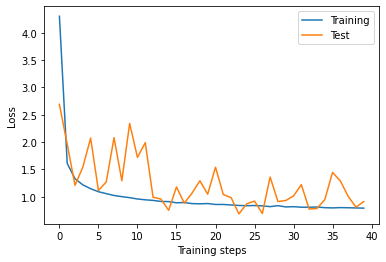

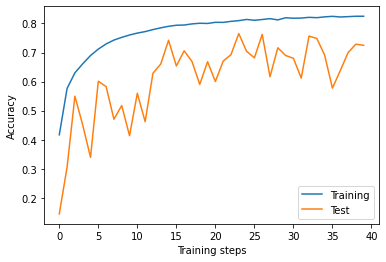

In [10]:
# Description: Figure 1 shows the loss for each epoch during the training and testing of the model.
#              Figure 2 shows the accuracy for each epoch during the training and testing of the model.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1, line2),("Training", "Test"))
plt.show()